# Object Detection Deployment As Rest API in AKS
This notebook guide you through the procoess of deploying a TF trained object detection model as a webservice in AKS using Microsoft's internal AML library at: https://github.com/Azure/ViennaDocs
Prerequisite: As the library is in FTE's private preview, you need to obtain approval and whitelist the subscription before you can use the library

# Imports

In [1]:
from distutils.version import StrictVersion
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("../models/research/")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

In [3]:
print("hello world")

hello world


## Object detection imports
Here are the imports from the object detection module.

In [4]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

../models/research/object_detection/utils/visualization_utils.py:25: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/james/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/james/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/james/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 497, in start
    self.io_loop.start()
 





# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [6]:
# What model to download.
MODEL_NAME = 'faster_rcnn_nas_coco_2018_01_28'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('../models/research/object_detection/data', 'mscoco_label_map.pbtxt')

NUM_CLASSES = 90

In [6]:
! more ../models/research/object_detection/data/mscoco_label_map.pbtxt


item {
  name: "/m/01g317"
  id: 1
  display_name: "person"
}
item {
  name: "/m/0199g"
  id: 2
  display_name: "bicycle"
}
item {
  name: "/m/0k4j"
  id: 3
  display_name: "car"
}
item {
  name: "/m/04_sv"
  id: 4
  display_name: "motorcycle"
}
item {
  name: "/m/05czz6l"
  id: 5
m--More--(5%)

In [7]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [21]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

## Download Model

In [6]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [55]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper code

In [29]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '../models/research/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)

In [10]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

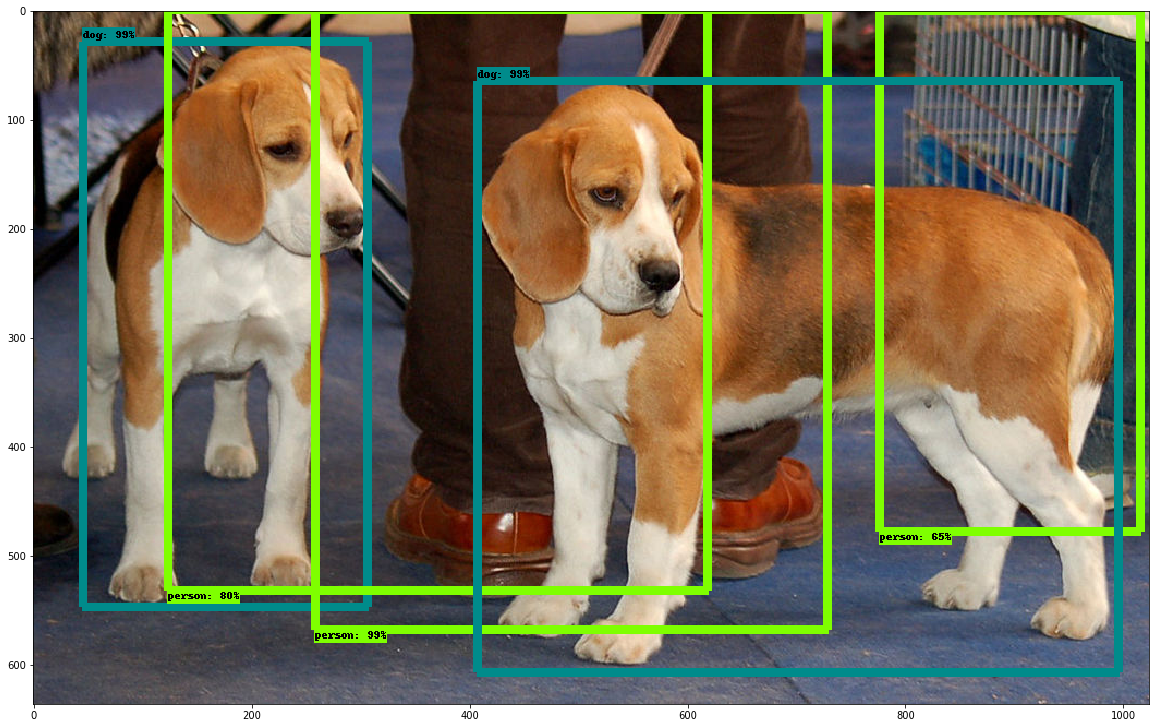

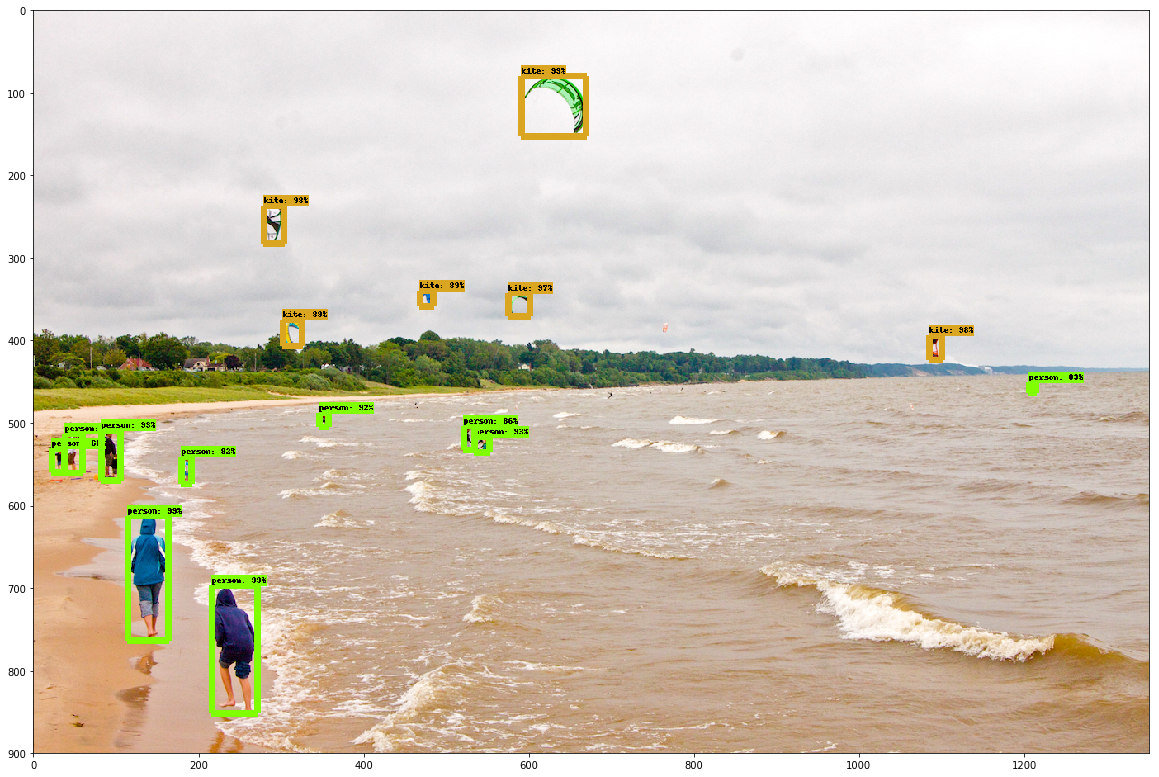

In [11]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
#   image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [14]:
%%writefile score.py
import json
import tensorflow as tf
# from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import base64
import sys
import os
import ast
from azureml.core.model import Model

sys.path.append("../models/research/")

# from object_detection.utils import visualization_utils as vis_util
# from object_detection.utils import label_map_util

def init():
    MODEL_NAME = 'object_detection'
    print("Tensorflow version: ", tf.__version__)
    model = Model.get_model_path(model_name=MODEL_NAME)

    # Path to frozen detection graph. This is the actual model that is used for the object detection.
#     PATH_TO_FROZEN_GRAPH ='faster_rcnn_nas_coco_2018_01_28/frozen_inference_graph.pb'
    global detection_graph
    with tf.device('/cpu:0'):

        detection_graph = tf.Graph()
        with detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            with tf.gfile.GFile(model, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
        
def run_inference_for_single_image(image, graph):
    config = tf.ConfigProto(
            device_count = {'GPU': 0})

    with graph.as_default():
        with tf.Session(config=config) as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
            # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                    feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8).tolist()
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0].tolist()
            output_dict['detection_scores'] = output_dict['detection_scores'][0].tolist()
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0].tolist()
    return output_dict
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)
def base64ToImg(base64ImgString):

    if base64ImgString.startswith('b\''):

        base64ImgString = base64ImgString[2:-1]

    base64Img   =  base64ImgString.encode('utf-8')

    decoded_img = base64.b64decode(base64Img)

    img_buffer  = BytesIO(decoded_img)

    img = Image.open(img_buffer)
    return img

def run(raw_data):
    
    #     for image_path in TEST_IMAGE_PATHS:
    #   image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    print(raw_data)
    data = json.loads(raw_data)['data']
    image = base64ToImg(data)
#     print("Image shape", image.shape)
    image_np = load_image_into_numpy_array(image)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    print("output is: ", output_dict)
    return json.dumps(output_dict)

#     return output_dict
if __name__ == "__main__":
    print("Hello in main")
    PATH_TO_LABELS = os.path.join('../models/research/object_detection/data', 'mscoco_label_map.pbtxt')
    NUM_CLASSES = 90
#     label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
#     categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
#     category_index = label_map_util.create_category_index(categories)

    init()
    PATH_TO_TEST_IMAGES_DIR = '../models/research/object_detection/test_images'
    TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

    # Size, in inches, of the output images.
    IMAGE_SIZE = (20, 20)
    with open(TEST_IMAGE_PATHS[0],"rb") as img:
        image_bytes = BytesIO(img.read())
    #image_data_1 = open(image_path_1, "rb").read()
    ENCODING = 'utf-8'
    # test_image = imresize(test_image,(width, height))
    payload = []
    encoded_image =base64.b64encode(image_bytes.getvalue())
    base64_string = encoded_image.decode(ENCODING)
# 
    image_request = {"data": "b'{0}'".format(base64_string)}
    # payload.append(image_request)
    # print(image_request)
    image_json = json.dumps(image_request)
#     print(image_json)

    output_dict = ast.literal_eval(run(image_json))
    
    print(output_dict)
#     image = Image.open(TEST_IMAGE_PATHS[0])

#     image_np = load_image_into_numpy_array(image)
#     vis_util.visualize_boxes_and_labels_on_image_array(
#     image_np,
#     np.array(output_dict['detection_boxes']),
#     np.array(output_dict['detection_classes']),
#     np.array(output_dict['detection_scores']),
#     category_index,
#     instance_masks=output_dict.get('detection_masks'),
#     use_normalized_coordinates=True,
#     line_thickness=8)
#     plt.figure(figsize=IMAGE_SIZE)
#     plt.imshow(image_np)

Overwriting score.py


In [5]:
#setup workspace
from azureml.core import Workspace, Run
import azureml.core

# Check core SDK version number
print("SDK version:", azureml.core.VERSION)
subscription_id = "0e9bace8-7a81-4922-83b5-d995ff706507"
resource_group = "dsvm"
workspace_name = "myws"
workspace_region = "eastus2" # or eastus2euap

ws = Workspace.create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = workspace_region)
ws.get_details()

SDK version: 0.1.4


{'applicationInsights': '/subscriptions/0e9bace8-7a81-4922-83b5-d995ff706507/resourcegroups/dsvm/providers/microsoft.insights/components/mywsinsightsnibxhihv',
 'batchaiWorkspace': '/subscriptions/0e9bace8-7a81-4922-83b5-d995ff706507/resourcegroups/dsvm/providers/microsoft.batchai/workspaces/mywsbatchai_efoulyhk',
 'containerRegistry': '/subscriptions/0e9bace8-7a81-4922-83b5-d995ff706507/resourcegroups/dsvm/providers/microsoft.containerregistry/registries/mywsacrlnovzifj',
 'description': '',
 'friendlyName': 'myws',
 'id': '/subscriptions/0e9bace8-7a81-4922-83b5-d995ff706507/resourceGroups/dsvm/providers/Microsoft.MachineLearningServices/workspaces/myws',
 'identityPrincipalId': '4fa893a2-ae15-44cc-a127-f7c62f474fac',
 'identityTenantId': '72f988bf-86f1-41af-91ab-2d7cd011db47',
 'identityType': 'SystemAssigned',
 'keyVault': '/subscriptions/0e9bace8-7a81-4922-83b5-d995ff706507/resourcegroups/dsvm/providers/microsoft.keyvault/vaults/mywskeyvaultxxeromxp',
 'location': 'eastus2',
 'name

In [8]:
#Writing conda yml file for installing additional python packages
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies()
myenv.add_conda_package("numpy")
myenv.add_conda_package("tensorflow==1.8.0")
myenv.add_conda_package("pillow")


# %%writefile score.py
# import json
# import tensorflow as tf
# # from matplotlib import pyplot as plt
# import numpy as np
# from PIL import Image

# from io import BytesIO
# import base64
# import sys
# import os
# import ast

with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [3]:
!more myenv.yml

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-fil
e-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - tensorflow
    # Required packages for AzureML execution, history, and data preparation.
  - --index-url https://azuremlsdktestpypi.azureedge.net/sdk-release/Preview/E75
01C02541B433786111FE8E140CAA1
  - --extra-index-url https://pypi.python.org/simple
  - azureml-defaults
- numpy
- pillow


In [ ]:
from azureml.core.webservice import AciWebservice, Webservice

aciconfig2 = AciWebservice.deploy_configuration(cpu_cores = 4, 
                                               memory_gb = 4, 
                                               tags = ['Object Detection Deployment'], 
                                               description = 'Object Detection Deployment')

from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "myenv.yml",
                                                  description = "Image with ridge regression model",
                                                  tags = ["diabetes","regression"]
                                                 )

image = ContainerImage.create(name = "myimage1",
                              # this is the model object
                              models = [model],
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

In [48]:
service.delete()

In [49]:
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script = "score.py", 
                                    runtime = "python", 
                                    conda_file = "myenv.yml")


In [ ]:
%%time
# this will take 5-10 minutes to finish
# you can also use "az container list" command to find the ACI being deployed
MODEL_NAME = 'faster_rcnn_nas_coco_2018_01_28'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
service = Webservice.deploy(name = 'my-aci-objdetection-5',
                                       deployment_config = aciconfig2,
                                       model_paths = [PATH_TO_FROZEN_GRAPH],
                                       image_config = image_config,
                                       workspace = ws)
service.wait_for_deployment(show_output = True)


In [25]:
print('web service is hosted in ACI:', service.scoring_uri)

web service is hosted in ACI: http://40.87.10.1:5001/score


In [6]:
#Register the model for aks
from azureml.core.model import Model
MODEL_NAME = 'faster_rcnn_nas_coco_2018_01_28'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
model = Model.register(model_path = PATH_TO_FROZEN_GRAPH, # this points to a local file
                       model_name = "object_detection", # this is the name the model is registered as
                       tags = ["object", "detection"],
                       description = "object detection",
                       workspace = ws)

print(model.name, model.description, model.version)

Registering model object_detection
object_detection object detection 1


In [18]:
#create an image
from azureml.core.image import ContainerImage

image_config = ContainerImage.image_configuration(execution_script = "score.py",
                                                  runtime = "python",
                                                  conda_file = "myenv.yml",
                                                  description = "Image for object_detection",
                                                  tags = ["object","detection"]
                                                 )

image = ContainerImage.create(name = "myimage1",
                              # this is the model object
                              models = [model],
                              image_config = image_config,
                              workspace = ws)

image.wait_for_creation(show_output = True)

Creating image
Running........................................
SucceededImage creation operation finished for image myimage1:2, operation "Succeeded"


In [9]:
%%time
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.webservice import Webservice, AksWebservice
# Use the default configuration (can also provide parameters to customize)
resource_id = '/subscriptions/0e9bace8-7a81-4922-83b5-d995ff706507/resourcegroups/dsvm/providers/Microsoft.ContainerService/managedClusters/my-aks5e1001646a12b09ed'

create_name='aks-obj-detect' 
# Create the cluster
aks_target = AksCompute.attach(workspace=ws, name=create_name, resource_id=resource_id)
# Wait for the operation to complete
aks_target.wait_for_provisioning(True)

Creating......................................................
SucceededAKS provisioning operation finished, operation "Succeeded"
CPU times: user 775 ms, sys: 33.1 ms, total: 808 ms
Wall time: 5min 5s


In [ ]:
#Set the web service configuration (using default here)
aks_config = AksWebservice.deploy_configuration()

In [19]:
%%time
aks_service_name ='aks-service-1'

aks_service = Webservice.deploy_from_image(workspace = ws, 
                                           name = aks_service_name,
                                           image = image,
                                           deployment_config = aks_config,
                                           deployment_target = aks_target)
aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

Creating service
Running...............
SucceededAKS service creation operation finished, operation "Succeeded"
{'desiredReplicas': 1, 'updatedReplicas': 1, 'availableReplicas': 1}
CPU times: user 346 ms, sys: 17.4 ms, total: 363 ms
Wall time: 1min 34s


In [21]:
aks_service.get_keys()

('0tv65AV8dgYZZJ2UMWhS6ZbYSvDrjUUO', '1RdbHWyBD0XN0vbK4Q156jA5SUeGkRG5')

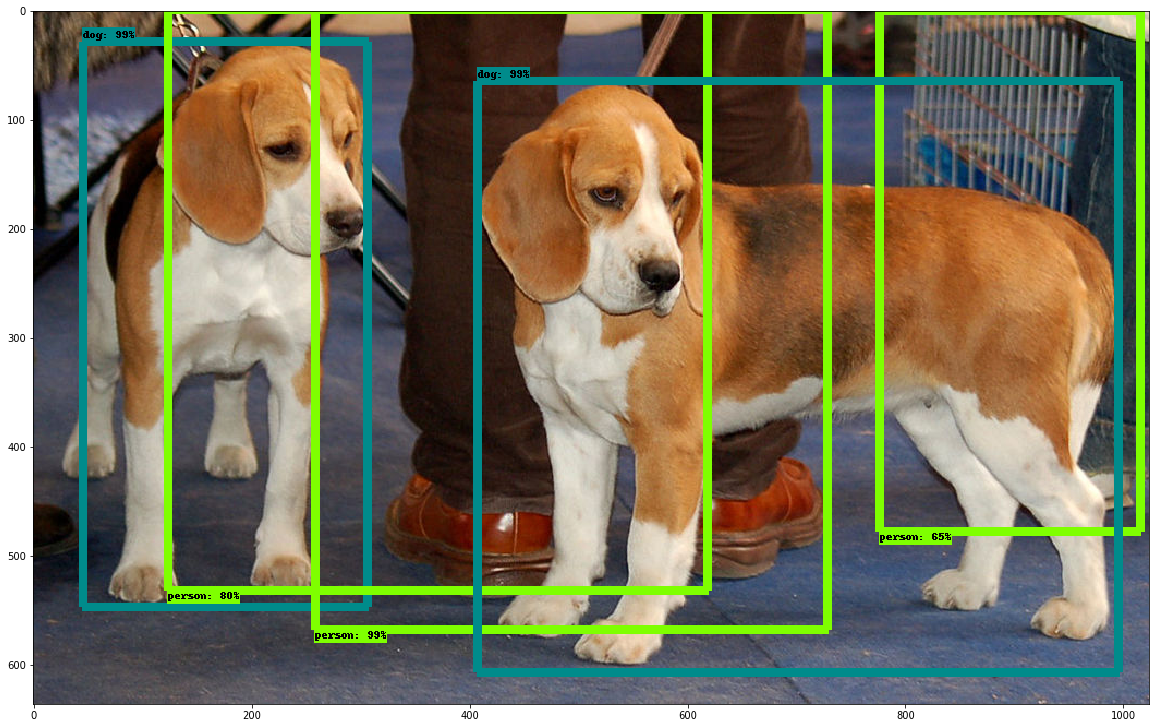

In [62]:
import requests
import json
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from io import BytesIO
import base64
import sys
import os
import ast
from azureml.core.model import Model

sys.path.append("../models/research/")

from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util


PATH_TO_LABELS = os.path.join('../models/research/object_detection/data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

PATH_TO_TEST_IMAGES_DIR = '../models/research/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (20, 20)
with open(TEST_IMAGE_PATHS[0],"rb") as img:
    image_bytes = BytesIO(img.read())
#image_data_1 = open(image_path_1, "rb").read()
ENCODING = 'utf-8'
# test_image = imresize(test_image,(width, height))
# payload = []
encoded_image =base64.b64encode(image_bytes.getvalue())
base64_string = encoded_image.decode(ENCODING)
# 
image_request = {"data": "b'{0}'".format(base64_string)}
# payload.append(image_request)

body = json.dumps(image_request)
# output = aks_service.run(input_data = body)
# print(output)

api_key = aks_service.get_keys()[0]
headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 
output = ast.literal_eval(requests.post(aks_service.scoring_uri, data=body, headers = headers).text)
# try:
#     result = json.loads(output.text)
#     json.loads(result[0])
# except:
#     raise ValueError("Incorrect output format. Result cant not be parsed: " + output.text)
# payload.append(image_request)
# print(image_request)
# image_json = json.dumps(image_request)
#     print(image_json)

output_dict = ast.literal_eval(output)


image = Image.open(TEST_IMAGE_PATHS[0])

image_np = load_image_into_numpy_array(image)
vis_util.visualize_boxes_and_labels_on_image_array(
image_np,
np.array(output_dict['detection_boxes']),
np.array(output_dict['detection_classes']),
np.array(output_dict['detection_scores']),
category_index,
instance_masks=output_dict.get('detection_masks'),
use_normalized_coordinates=True,
line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)